# Train NIO Model
This notebook will develop and train a neural network to predict the percent change in the NIO price.
It will utilize grid search to find the best hyperparameters

## Enviornment setups

In [1]:
# Import packages

# General Utility
from datetime import datetime
import datetime, time
from datetime import timedelta

# Data processing
import numpy as np
import pandas as pd
import pickle
from sklearn.preprocessing import RobustScaler

# Plotting
import matplotlib.pyplot as plt

import torch

# Diamond-Hands
import sys
sys.path.append('../Packages/')
import diamond_hands as dh

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
tickr = 'NIO'

In [3]:
# Data Locations
processed_input_dir = '../../Data/ProcessedInputs/'
model_dir = '../../Data/Models/'
grid_result_dir = model_dir+tickr+'/'
fine_grid_result_dir = model_dir+tickr+'/Fine/'
pred_dir = '../../Data/Predictions/'
final_model_dir = '../../Data/Models/Final/'

In [4]:
TRAIN_ON_GPU, TRAIN_ON_MULTI_GPUS = dh.setupPytorch()

Training on 4 GPUs!


In [5]:
with open(processed_input_dir+tickr+'_input_data.bin','rb') as f:
    df = pickle.load(f)
with open(processed_input_dir+tickr+'_output_data.bin','rb') as f:
    output_data = pickle.load(f)
with open(model_dir+tickr+'_scaler.bin','rb') as f:
    scaler = pickle.load(f)

In [6]:
df = df[:-1]

In [7]:
df['2021-03-01':]

,P_Change,volume_adi,volume_obv,volume_cmf,volume_fi,volume_mfi,volume_em,volume_sma_em,volume_vpt,volume_nvi,...,Tomorrow_Tickr_#Pos,Tomorrow_Tickr_W#Neg,Tomorrow_Tickr_W#Neu,Tomorrow_Tickr_W#Pos,Tomorrow_Tickr_%Neg,Tomorrow_Tickr_%Neu,Tomorrow_Tickr_%Pos,Tomorrow_Tickr_W%Neg,Tomorrow_Tickr_W%Neu,Tomorrow_Tickr_W%Pos
Date,,,,,,,,,,,,,,,,,,,,,
2021-03-01,-0.636057,4.396770,2.525555,0.304323,-1.811674,-0.471019,24.278967,-28.334684,1.341557,0.021415,...,109.0,337.0,1438.0,551.0,0.150862,0.614224,0.234914,0.141835,0.605219,0.231902
2021-03-02,-0.411724,4.269211,2.452879,-0.012875,-8.670150,-0.892569,-33.212003,-43.055373,-3.043931,0.021415,...,90.0,234.0,786.0,433.0,0.109848,0.549242,0.340909,0.151456,0.508738,0.280259
2021-03-03,-1.181097,4.176143,2.404582,-0.186168,-8.727142,-1.240172,-19.346854,-51.786698,-5.919446,-0.007406,...,46.0,162.0,497.0,279.0,0.135714,0.535714,0.328571,0.172708,0.529851,0.297441
2021-03-04,-0.381381,4.108016,2.312178,-0.416916,-10.633494,-1.311281,-21.128549,-52.528821,-3.613717,-0.007406,...,30.0,176.0,375.0,97.0,0.171429,0.542857,0.285714,0.263473,0.561377,0.145210
2021-03-05,-0.735792,4.274657,2.189944,-0.020029,-11.286712,-1.404520,-35.078742,-55.694196,-4.484087,-0.007406,...,27.0,59.0,316.0,139.0,0.136364,0.556818,0.306818,0.114341,0.612403,0.269380
2021-03-08,0.205422,4.138766,2.125641,-0.220619,-12.503555,-1.601095,12.099553,-54.450993,-4.425435,-0.059159,...,29.0,82.0,467.0,170.0,0.106796,0.611650,0.281553,0.113731,0.647712,0.235784
2021-03-09,2.134305,4.282161,2.205202,-0.061146,-3.345392,-1.269045,19.271499,-44.064822,4.663396,-0.059159,...,29.0,25.0,424.0,194.0,0.063830,0.627660,0.308511,0.038521,0.653313,0.298921
2021-03-10,0.308081,4.161623,2.119111,-0.389413,-2.917426,-0.935963,26.279377,-30.219452,7.170178,-0.059159,...,26.0,15.0,225.0,169.0,0.084507,0.549296,0.366197,0.034483,0.517241,0.388506
2021-03-11,-0.250734,4.298408,2.179770,-0.091045,1.806299,-0.822301,12.486391,-29.237596,3.558670,0.012465,...,50.0,66.0,623.0,531.0,0.076389,0.576389,0.347222,0.053746,0.507329,0.432410


In [8]:
n_test=37

## Grid Search

In [9]:
# Configure search space
n_features = [df.shape[1]]
n_periods = [1,5,10,20,40,60]
n_hidden = [10,50,100]
n_layers = [2,3]
drop_prob = [0.1,0.25,0.5]
lr = [0.001,0.01]
clip = [1,5,10]
batch_size = [400]

In [10]:
# use grid search to optimize hyperparameters
grid_result = []
dh.gridSearch(grid_results = grid_result,
              tickr=tickr,
                           n_features=n_features,
                           n_periods=n_periods,
                           n_hidden=n_hidden,
                           n_layers=n_layers,
                           drop_prob=drop_prob,
                           lr=lr,
                           clip=clip,
                           batch_size=batch_size,
                           data=df,
                           epochs=10,
                           n_test=n_test,
                           n_steps_out=1,
                          fpath=grid_result_dir,
                           TRAIN_ON_GPU=TRAIN_ON_GPU,
                           TRAIN_ON_MULTI_GPUS=TRAIN_ON_MULTI_GPUS)

Hyper Parameter search across 648 different configurations.
Iteration: 1 |periods: 1|hidden: 10|layers: 2|drop: 0.1|lr: 0.001|clip: 1


C:\Environments\python37\lib\site-packages\torch\cuda\nccl.py:16: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')


Training complete in 0m 25s
Iteration: 2 |periods: 5|hidden: 10|layers: 2|drop: 0.1|lr: 0.001|clip: 1
Training complete in 0m 3s
Iteration: 3 |periods: 10|hidden: 10|layers: 2|drop: 0.1|lr: 0.001|clip: 1
Training complete in 0m 3s
Iteration: 4 |periods: 20|hidden: 10|layers: 2|drop: 0.1|lr: 0.001|clip: 1
Training complete in 0m 3s
Iteration: 5 |periods: 40|hidden: 10|layers: 2|drop: 0.1|lr: 0.001|clip: 1
Training complete in 0m 5s
Iteration: 6 |periods: 60|hidden: 10|layers: 2|drop: 0.1|lr: 0.001|clip: 1
Training complete in 0m 6s
Iteration: 7 |periods: 1|hidden: 50|layers: 2|drop: 0.1|lr: 0.001|clip: 1
Training complete in 0m 2s
Iteration: 8 |periods: 5|hidden: 50|layers: 2|drop: 0.1|lr: 0.001|clip: 1
Training complete in 0m 2s
Iteration: 9 |periods: 10|hidden: 50|layers: 2|drop: 0.1|lr: 0.001|clip: 1
Training complete in 0m 3s
Iteration: 10 |periods: 20|hidden: 50|layers: 2|drop: 0.1|lr: 0.001|clip: 1
Training complete in 0m 4s
Iteration: 11 |periods: 40|hidden: 50|layers: 2|drop: 0.

Training complete in 0m 4s
Iteration: 82 |periods: 20|hidden: 50|layers: 2|drop: 0.5|lr: 0.001|clip: 1
Training complete in 0m 4s
Iteration: 83 |periods: 40|hidden: 50|layers: 2|drop: 0.5|lr: 0.001|clip: 1
Training complete in 0m 6s
Iteration: 84 |periods: 60|hidden: 50|layers: 2|drop: 0.5|lr: 0.001|clip: 1
Training complete in 0m 7s
Iteration: 85 |periods: 1|hidden: 100|layers: 2|drop: 0.5|lr: 0.001|clip: 1
Training complete in 0m 3s
Iteration: 86 |periods: 5|hidden: 100|layers: 2|drop: 0.5|lr: 0.001|clip: 1
Training complete in 0m 3s
Iteration: 87 |periods: 10|hidden: 100|layers: 2|drop: 0.5|lr: 0.001|clip: 1
Training complete in 0m 4s
Iteration: 88 |periods: 20|hidden: 100|layers: 2|drop: 0.5|lr: 0.001|clip: 1
Training complete in 0m 5s
Iteration: 89 |periods: 40|hidden: 100|layers: 2|drop: 0.5|lr: 0.001|clip: 1
Training complete in 0m 7s
Iteration: 90 |periods: 60|hidden: 100|layers: 2|drop: 0.5|lr: 0.001|clip: 1
Training complete in 0m 8s
Iteration: 91 |periods: 1|hidden: 10|layer

Training complete in 0m 7s
Iteration: 162 |periods: 60|hidden: 100|layers: 2|drop: 0.25|lr: 0.01|clip: 1
Training complete in 0m 9s
Iteration: 163 |periods: 1|hidden: 10|layers: 3|drop: 0.25|lr: 0.01|clip: 1
Training complete in 0m 3s
Iteration: 164 |periods: 5|hidden: 10|layers: 3|drop: 0.25|lr: 0.01|clip: 1
Training complete in 0m 4s
Iteration: 165 |periods: 10|hidden: 10|layers: 3|drop: 0.25|lr: 0.01|clip: 1
Training complete in 0m 4s
Iteration: 166 |periods: 20|hidden: 10|layers: 3|drop: 0.25|lr: 0.01|clip: 1
Training complete in 0m 5s
Iteration: 167 |periods: 40|hidden: 10|layers: 3|drop: 0.25|lr: 0.01|clip: 1
Training complete in 0m 9s
Iteration: 168 |periods: 60|hidden: 10|layers: 3|drop: 0.25|lr: 0.01|clip: 1
Training complete in 0m 12s
Iteration: 169 |periods: 1|hidden: 50|layers: 3|drop: 0.25|lr: 0.01|clip: 1
Training complete in 0m 3s
Iteration: 170 |periods: 5|hidden: 50|layers: 3|drop: 0.25|lr: 0.01|clip: 1
Training complete in 0m 3s
Iteration: 171 |periods: 10|hidden: 50|

Training complete in 0m 3s
Iteration: 242 |periods: 5|hidden: 50|layers: 3|drop: 0.1|lr: 0.001|clip: 5
Training complete in 0m 3s
Iteration: 243 |periods: 10|hidden: 50|layers: 3|drop: 0.1|lr: 0.001|clip: 5
Training complete in 0m 4s
Iteration: 244 |periods: 20|hidden: 50|layers: 3|drop: 0.1|lr: 0.001|clip: 5
Training complete in 0m 6s
Iteration: 245 |periods: 40|hidden: 50|layers: 3|drop: 0.1|lr: 0.001|clip: 5
Training complete in 0m 8s
Iteration: 246 |periods: 60|hidden: 50|layers: 3|drop: 0.1|lr: 0.001|clip: 5
Training complete in 0m 12s
Iteration: 247 |periods: 1|hidden: 100|layers: 3|drop: 0.1|lr: 0.001|clip: 5
Training complete in 0m 3s
Iteration: 248 |periods: 5|hidden: 100|layers: 3|drop: 0.1|lr: 0.001|clip: 5
Training complete in 0m 4s
Iteration: 249 |periods: 10|hidden: 100|layers: 3|drop: 0.1|lr: 0.001|clip: 5
Training complete in 0m 5s
Iteration: 250 |periods: 20|hidden: 100|layers: 3|drop: 0.1|lr: 0.001|clip: 5
Training complete in 0m 6s
Iteration: 251 |periods: 40|hidden:

Training complete in 0m 4s
Iteration: 321 |periods: 10|hidden: 100|layers: 3|drop: 0.5|lr: 0.001|clip: 5
Training complete in 0m 5s
Iteration: 322 |periods: 20|hidden: 100|layers: 3|drop: 0.5|lr: 0.001|clip: 5
Training complete in 0m 6s
Iteration: 323 |periods: 40|hidden: 100|layers: 3|drop: 0.5|lr: 0.001|clip: 5
Training complete in 0m 9s
Iteration: 324 |periods: 60|hidden: 100|layers: 3|drop: 0.5|lr: 0.001|clip: 5
Training complete in 0m 13s
Iteration: 325 |periods: 1|hidden: 10|layers: 2|drop: 0.1|lr: 0.01|clip: 5
Training complete in 0m 3s
Iteration: 326 |periods: 5|hidden: 10|layers: 2|drop: 0.1|lr: 0.01|clip: 5
Training complete in 0m 3s
Iteration: 327 |periods: 10|hidden: 10|layers: 2|drop: 0.1|lr: 0.01|clip: 5
Training complete in 0m 3s
Iteration: 328 |periods: 20|hidden: 10|layers: 2|drop: 0.1|lr: 0.01|clip: 5
Training complete in 0m 4s
Iteration: 329 |periods: 40|hidden: 10|layers: 2|drop: 0.1|lr: 0.01|clip: 5
Training complete in 0m 6s
Iteration: 330 |periods: 60|hidden: 10|

Training complete in 0m 4s
Iteration: 401 |periods: 40|hidden: 10|layers: 2|drop: 0.5|lr: 0.01|clip: 5
Training complete in 0m 6s
Iteration: 402 |periods: 60|hidden: 10|layers: 2|drop: 0.5|lr: 0.01|clip: 5
Training complete in 0m 7s
Iteration: 403 |periods: 1|hidden: 50|layers: 2|drop: 0.5|lr: 0.01|clip: 5
Training complete in 0m 3s
Iteration: 404 |periods: 5|hidden: 50|layers: 2|drop: 0.5|lr: 0.01|clip: 5
Training complete in 0m 3s
Iteration: 405 |periods: 10|hidden: 50|layers: 2|drop: 0.5|lr: 0.01|clip: 5
Training complete in 0m 3s
Iteration: 406 |periods: 20|hidden: 50|layers: 2|drop: 0.5|lr: 0.01|clip: 5
Training complete in 0m 4s
Iteration: 407 |periods: 40|hidden: 50|layers: 2|drop: 0.5|lr: 0.01|clip: 5
Training complete in 0m 5s
Iteration: 408 |periods: 60|hidden: 50|layers: 2|drop: 0.5|lr: 0.01|clip: 5
Training complete in 0m 7s
Iteration: 409 |periods: 1|hidden: 100|layers: 2|drop: 0.5|lr: 0.01|clip: 5
Training complete in 0m 2s
Iteration: 410 |periods: 5|hidden: 100|layers: 2

Training complete in 0m 6s
Iteration: 480 |periods: 60|hidden: 50|layers: 2|drop: 0.25|lr: 0.001|clip: 10
Training complete in 0m 8s
Iteration: 481 |periods: 1|hidden: 100|layers: 2|drop: 0.25|lr: 0.001|clip: 10
Training complete in 0m 3s
Iteration: 482 |periods: 5|hidden: 100|layers: 2|drop: 0.25|lr: 0.001|clip: 10
Training complete in 0m 3s
Iteration: 483 |periods: 10|hidden: 100|layers: 2|drop: 0.25|lr: 0.001|clip: 10
Training complete in 0m 4s
Iteration: 484 |periods: 20|hidden: 100|layers: 2|drop: 0.25|lr: 0.001|clip: 10
Training complete in 0m 5s
Iteration: 485 |periods: 40|hidden: 100|layers: 2|drop: 0.25|lr: 0.001|clip: 10
Training complete in 0m 6s
Iteration: 486 |periods: 60|hidden: 100|layers: 2|drop: 0.25|lr: 0.001|clip: 10
Training complete in 0m 8s
Iteration: 487 |periods: 1|hidden: 10|layers: 3|drop: 0.25|lr: 0.001|clip: 10
Training complete in 0m 3s
Iteration: 488 |periods: 5|hidden: 10|layers: 3|drop: 0.25|lr: 0.001|clip: 10
Training complete in 0m 3s
Iteration: 489 |p

Training complete in 0m 6s
Iteration: 558 |periods: 60|hidden: 100|layers: 2|drop: 0.1|lr: 0.01|clip: 10
Training complete in 0m 8s
Iteration: 559 |periods: 1|hidden: 10|layers: 3|drop: 0.1|lr: 0.01|clip: 10
Training complete in 0m 3s
Iteration: 560 |periods: 5|hidden: 10|layers: 3|drop: 0.1|lr: 0.01|clip: 10
Training complete in 0m 4s
Iteration: 561 |periods: 10|hidden: 10|layers: 3|drop: 0.1|lr: 0.01|clip: 10
Training complete in 0m 4s
Iteration: 562 |periods: 20|hidden: 10|layers: 3|drop: 0.1|lr: 0.01|clip: 10
Training complete in 0m 6s
Iteration: 563 |periods: 40|hidden: 10|layers: 3|drop: 0.1|lr: 0.01|clip: 10
Training complete in 0m 9s
Iteration: 564 |periods: 60|hidden: 10|layers: 3|drop: 0.1|lr: 0.01|clip: 10
Training complete in 0m 11s
Iteration: 565 |periods: 1|hidden: 50|layers: 3|drop: 0.1|lr: 0.01|clip: 10
Training complete in 0m 3s
Iteration: 566 |periods: 5|hidden: 50|layers: 3|drop: 0.1|lr: 0.01|clip: 10
Training complete in 0m 4s
Iteration: 567 |periods: 10|hidden: 50|

Training complete in 0m 10s
Iteration: 637 |periods: 1|hidden: 50|layers: 3|drop: 0.5|lr: 0.01|clip: 10
Training complete in 0m 3s
Iteration: 638 |periods: 5|hidden: 50|layers: 3|drop: 0.5|lr: 0.01|clip: 10
Training complete in 0m 3s
Iteration: 639 |periods: 10|hidden: 50|layers: 3|drop: 0.5|lr: 0.01|clip: 10
Training complete in 0m 4s
Iteration: 640 |periods: 20|hidden: 50|layers: 3|drop: 0.5|lr: 0.01|clip: 10
Training complete in 0m 6s
Iteration: 641 |periods: 40|hidden: 50|layers: 3|drop: 0.5|lr: 0.01|clip: 10
Training complete in 0m 9s
Iteration: 642 |periods: 60|hidden: 50|layers: 3|drop: 0.5|lr: 0.01|clip: 10
Training complete in 0m 12s
Iteration: 643 |periods: 1|hidden: 100|layers: 3|drop: 0.5|lr: 0.01|clip: 10
Training complete in 0m 3s
Iteration: 644 |periods: 5|hidden: 100|layers: 3|drop: 0.5|lr: 0.01|clip: 10
Training complete in 0m 4s
Iteration: 645 |periods: 10|hidden: 100|layers: 3|drop: 0.5|lr: 0.01|clip: 10
Training complete in 0m 5s
Iteration: 646 |periods: 20|hidden: 

In [11]:
with open(model_dir+tickr+'_grid_search_result.bin','wb') as f:
    pickle.dump(grid_result,f)

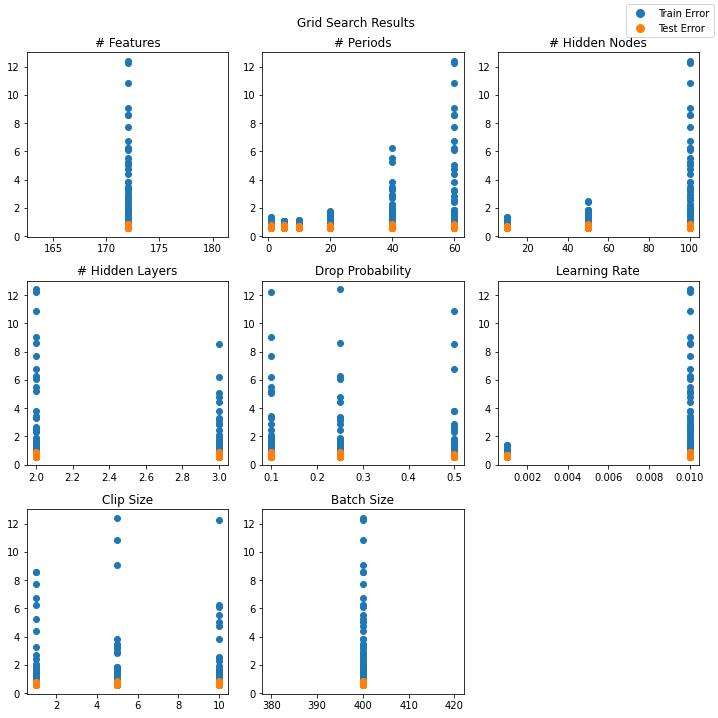

In [12]:
dh.visualizeGridSearch(grid_result)

In [13]:
resultdf = dh.resultDF(grid_result)

In [14]:
sorted_results = resultdf.sort_values(by=['Test Error'])
sorted_results

,Train Error,Test Error,# Features,# Periods,# Hidden Nodes,# Hidden Layers,Drop Probability,Learning Rate,Clip Size,Batch Size
15,0.965761,0.538283,172.0,20.0,100.0,2.0,0.10,0.001,1.0,400.0
369,0.997327,0.539653,172.0,20.0,50.0,2.0,0.25,0.010,5.0,400.0
83,0.955966,0.541102,172.0,60.0,50.0,2.0,0.50,0.001,1.0,400.0
232,0.935931,0.546800,172.0,40.0,100.0,2.0,0.10,0.001,5.0,400.0
401,0.964076,0.547228,172.0,60.0,10.0,2.0,0.50,0.010,5.0,400.0
...,...,...,...,...,...,...,...,...,...,...
587,2.465638,0.780660,172.0,60.0,50.0,2.0,0.25,0.010,10.0,400.0
132,1.126135,0.808687,172.0,1.0,50.0,3.0,0.10,0.010,1.0,400.0
592,6.245981,0.860105,172.0,40.0,100.0,2.0,0.25,0.010,10.0,400.0
359,3.275318,0.864460,172.0,60.0,100.0,3.0,0.10,0.010,5.0,400.0


## Fine Grid Search

In [15]:
best_model_id = sorted_results.index[0]

In [16]:
with open(grid_result_dir+str(best_model_id+1)+'.model','rb') as f:
    model = torch.load(f)
model.eval()


StockLSTM(
  (lstm): LSTM(172, 100, num_layers=2, batch_first=True, dropout=0.1)
  (dropout): Dropout(p=0.1, inplace=False)
  (fc): Linear(in_features=2000, out_features=1, bias=True)
)

In [17]:
# Configure search space
n_features = [df.shape[1]]
n_periods = [model.n_periods]
n_hidden = [model.n_hidden]
n_layers = [model.n_layers]
drop_prob = [model.drop_prob]
lr = [model.lr]
clip = [model.clip]
#batch_size = [1,5,10,20,40,60,120,240]
batch_size = [4,20,40,80,240,480,960]
epochs = [10,25,50,100,250,500]

In [19]:
batch_size = [20,40,80,240,480,960]
epochs = [500]

In [20]:
# use fine grid search to optimize hyperparameters
#fine_grid_result = []
dh.finegridSearch(grid_results = fine_grid_result,
              tickr=tickr,
                           n_features=n_features,
                           n_periods=n_periods,
                           n_hidden=n_hidden,
                           n_layers=n_layers,
                           drop_prob=drop_prob,
                           lr=lr,
                           clip=clip,
                           batch_size=batch_size,
                           data=df,
                           epochs=epochs,
                           n_test=n_test,
                           n_steps_out=1,
                          fpath=fine_grid_result_dir,
                           TRAIN_ON_GPU=TRAIN_ON_GPU,
                           TRAIN_ON_MULTI_GPUS=TRAIN_ON_MULTI_GPUS)

Hyper Parameter search across 6 different configurations.
Iteration: 1 |epochs: 500|periods: 20|hidden: 100|layers: 2|drop: 0.1|lr: 0.001|clip: 1
Training complete in 53m 28s
Iteration: 2 |epochs: 500|periods: 20|hidden: 100|layers: 2|drop: 0.1|lr: 0.001|clip: 1
Training complete in 25m 14s
Iteration: 3 |epochs: 500|periods: 20|hidden: 100|layers: 2|drop: 0.1|lr: 0.001|clip: 1
Training complete in 12m 56s
Iteration: 4 |epochs: 500|periods: 20|hidden: 100|layers: 2|drop: 0.1|lr: 0.001|clip: 1
Training complete in 5m 29s
Iteration: 5 |epochs: 500|periods: 20|hidden: 100|layers: 2|drop: 0.1|lr: 0.001|clip: 1
Training complete in 3m 58s
Iteration: 6 |epochs: 500|periods: 20|hidden: 100|layers: 2|drop: 0.1|lr: 0.001|clip: 1
Training complete in 2m 32s
Grid search complete in 103m 38s


In [21]:
with open(model_dir+tickr+'fine_grid_search_result.bin','wb') as f:
    pickle.dump(fine_grid_result,f)

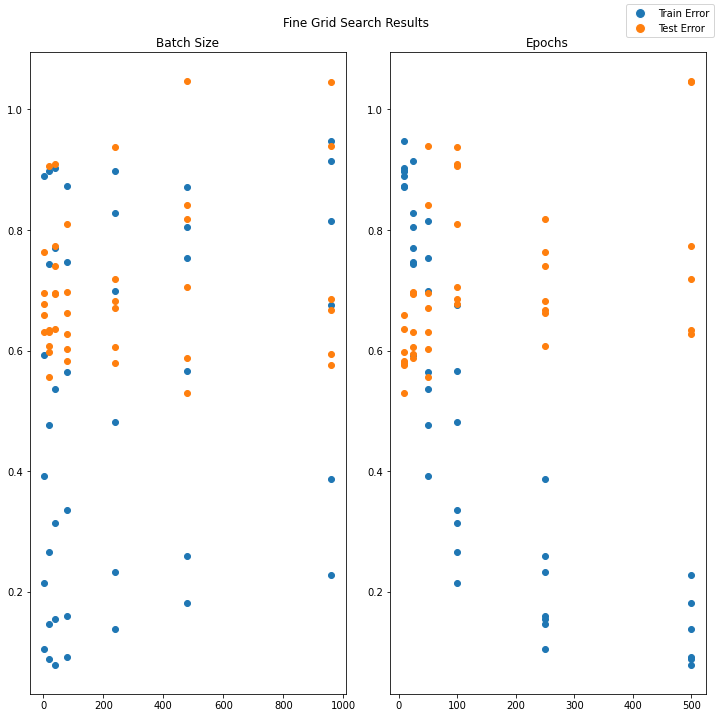

In [22]:
dh.visualizeFineGridSearch(fine_grid_result)

In [23]:
resultdf = dh.resultDFFine(fine_grid_result)

In [24]:
sorted_results = resultdf.sort_values(by=['Test Error'])
sorted_results

,Train Error,Test Error,# Features,# Periods,# Hidden Nodes,# Hidden Layers,Drop Probability,Learning Rate,Clip Size,Batch Size,Epochs
5,0.871416,0.530069,172.0,20.0,100.0,2.0,0.1,0.001,1.0,480.0,10.0
15,0.476243,0.556664,172.0,20.0,100.0,2.0,0.1,0.001,1.0,20.0,50.0
6,0.947205,0.575769,172.0,20.0,100.0,2.0,0.1,0.001,1.0,960.0,10.0
4,0.898344,0.579546,172.0,20.0,100.0,2.0,0.1,0.001,1.0,240.0,10.0
3,0.872323,0.583621,172.0,20.0,100.0,2.0,0.1,0.001,1.0,80.0,10.0
12,0.804727,0.588514,172.0,20.0,100.0,2.0,0.1,0.001,1.0,480.0,25.0
13,0.914135,0.594007,172.0,20.0,100.0,2.0,0.1,0.001,1.0,960.0,25.0
1,0.898412,0.598259,172.0,20.0,100.0,2.0,0.1,0.001,1.0,20.0,10.0
17,0.564353,0.602861,172.0,20.0,100.0,2.0,0.1,0.001,1.0,80.0,50.0
11,0.827812,0.606754,172.0,20.0,100.0,2.0,0.1,0.001,1.0,240.0,25.0


## Evaluate Final Model

In [25]:
#best_model_id = sorted_results.index[0]
best_model_id = 16
with open(fine_grid_result_dir+str(best_model_id+1)+'.model','rb') as f:
    model = torch.load(f)
model.eval()

StockLSTM(
  (lstm): LSTM(172, 100, num_layers=2, batch_first=True, dropout=0.1)
  (dropout): Dropout(p=0.1, inplace=False)
  (fc): Linear(in_features=2000, out_features=1, bias=True)
)

Training RMSE: 0.8151073408773674
Test RMSE: 2.459089316302848
Training MAE: 0.2804654373833038
Test MAE: 1.7735221492377191
Training - Above Error: $0.30 (55.69%) Below Error: $-0.26 (44.31%)
Test - Above Error: $1.87 (48.65%) Below Error: $-1.68 (51.35%)


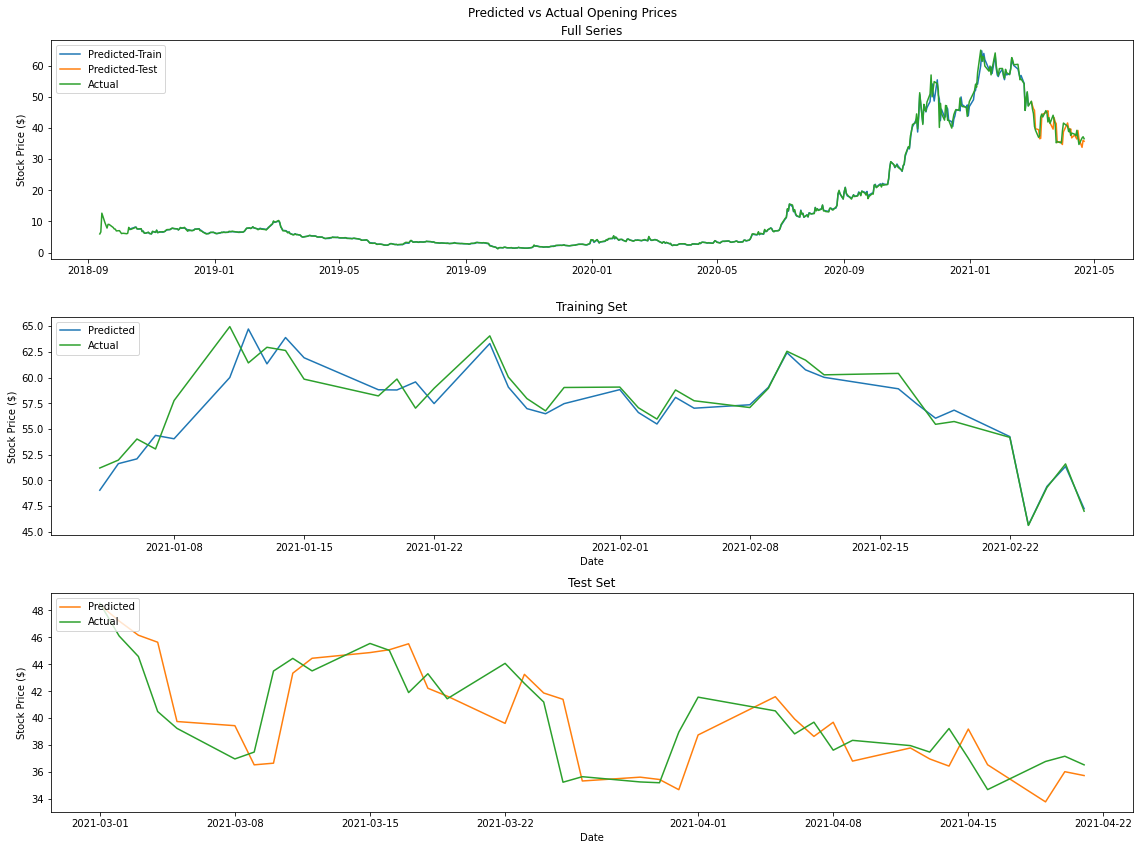

In [26]:
preds = dh.evaluateModel(model=model,
             input_data=df,
             output_data=output_data[:-1],
             scaler=scaler,
             n_steps_in=model.n_periods,
             n_steps_out=1,
             n_test=n_test)

In [27]:
preds.tail()

,Open,Raw_Predictions,Prediction_Type,Predicted
Date,,,,
2021-04-15,37.020000,-0.013053,Test,39.189089
2021-04-16,34.689999,-0.026224,Test,36.536772
2021-04-19,36.779999,-0.020611,Test,33.780273
2021-04-20,37.169998,-0.038617,Test,36.021938
2021-04-21,36.529999,-0.009983,Test,35.734599


In [28]:
with open(pred_dir+tickr+'_pred.bin','wb') as f:
    pickle.dump(preds,f)

In [29]:
with open(final_model_dir+tickr+'_model.model','wb') as f:
    torch.save(model,f)